In [1]:
import dataset as dataset
import importlib
importlib.reload(dataset)
import utils as utils
import tensorflow as tf
import numpy as np
import model as model

# tf.compat.v1.enable_eager_execution()
num_classes = 8

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Define architecture

In [2]:
class Mlpnet(tf.keras.Model):
    def __init__(self, strName, intChans, numIn):
        super(Mlpnet, self).__init__(name=strName)
        self.moduleIn = tf.keras.Sequential(
            [model.net_dense("dense_1", intChans[0], input_shape=(numIn * 3,))], name="in_0")
        self.moduleMain = model.Mlpnet("main", intChans)
        self.moduleOut = tf.keras.Sequential(
            [tf.keras.layers.Dense(num_classes, activation=None)], name="out_0")
    
    def call(self, tenIn):
        tenOut = self.moduleIn(tenIn)
        tenOut = self.moduleMain(tenOut)
        return self.moduleOut(tenOut)

## Import dataset

In [3]:
train_txt = './train_6.txt'
val_txt = './val_6.txt'
batch_size = 1
size = (128, 256)
num_bins = 128
architecture_depth = []
for i in range(4):
    architecture_depth.insert(0, np.power(2, (8 - i)))
# mainmodel = Unet('main', architecture_depth, 'regular')
mainmodel = Mlpnet('main', architecture_depth, num_bins)
next_batch = dataset.input_fn(
    dataset_name='hist',
    train_txt_paths=[train_txt],
    eval_txt_paths=[val_txt],
    is_train=True,
    image_size=size,
    batch_size=batch_size)
next_batch_val = dataset.input_fn(
    dataset_name='hist',
    train_txt_paths=[train_txt],
    eval_txt_paths=[val_txt],
    is_train=False,
    image_size=size,
    batch_size=batch_size)
inputs = next_batch['hist']
inputs_val = next_batch_val['hist']

inputs.set_shape([batch_size, num_bins * 3])
inputs_val.set_shape([batch_size, num_bins * 3])

class_predict = mainmodel(inputs)
class_predict_val = mainmodel(inputs_val)

class_gt = next_batch['label']  # a scalar of int32
class_gt_val = next_batch_val['label']

class_gt = tf.cast(class_gt, tf.float32)
class_gt_val = tf.cast(class_gt_val, tf.float32)

print(class_gt.shape)




Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
(1, 8)


## Define losses

In [4]:
# define losses
loss = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=class_gt, logits=class_predict)
# loss = tf.reduce_mean(tf.abs(class_one_hot - class_predict))
# Evaluation metrics
prediction = tf.to_int32(tf.argmax(class_predict, 1))
ground_truth = tf.to_int32(tf.argmax(class_gt, 1))
correct_prediction = tf.equal(prediction, ground_truth)

prediction_val = tf.to_int32(tf.argmax(class_predict_val, 1))
ground_truth_val = tf.to_int32(tf.argmax(class_gt_val, 1))
correct_prediction_val = tf.equal(prediction_val, ground_truth_val)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
accuracy_val = tf.reduce_mean(tf.cast(correct_prediction_val, tf.float32))

global_step = tf.compat.v1.train.get_or_create_global_step()
learning_rate = tf.compat.v1.train.exponential_decay(
  5e-5, global_step, 5000, 0.9, staircase=False)
opt = tf.compat.v1.train.AdamOptimizer(
    learning_rate=learning_rate).minimize(loss, global_step=global_step)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.


In [ ]:
restore = False
max_steps = 1000000
fetch_list = [opt, accuracy, accuracy_val, class_predict, class_gt, loss]
trainable_var_list = [
      var for var in tf.compat.v1.trainable_variables()
  ]
saver = tf.compat.v1.train.Saver(trainable_var_list, max_to_keep=5)
sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())

if restore:
    model_path = '/home/bmild/comp-color/data/ckpts_hist'
    saver_restore = tf.train.Saver(trainable_var_list)
    ckpt = tf.train.get_checkpoint_state(model_path)
    restore_path = ckpt.model_checkpoint_path
    saver_restore.restore(sess, restore_path)


all_loss = np.zeros(max_steps, dtype=float)
sses = np.zeros(max_steps)
for step in range(max_steps):
    _, out_accuracy, out_accuracy_val, out_class_predict, out_class_gt, out_loss = sess.run(fetch_list)
    all_loss[step] = np.mean(out_loss)
    if step % 100 == 0:
        print('Accuracy:', out_accuracy)
        print('Validation Accuracy:', out_accuracy_val)
        print('Correct class label:', out_class_gt)
        print('Class prediction:', out_class_predict)
        print('Average loss:', np.mean(all_loss[np.where(all_loss)]))
    if step % 1000 == 0:
        saver.save(sess, '%s/model.ckpt' % ('/home/bmild/comp-color/data/ckpts_hist_2'), global_step=step)

Accuracy: 0.0
Validation Accuracy: 0.0
Correct class label: [[0. 0. 1. 0. 0. 0. 0. 0.]]
Class prediction: [[-0.15356557  0.02323409 -0.07816968 -0.163486    0.17665854  0.01192298
  -0.07722808 -0.02853729]]
Average loss: 0.6863294839859009
Accuracy: 0.0
Validation Accuracy: 0.0
Correct class label: [[0. 0. 1. 0. 0. 1. 1. 0.]]
Class prediction: [[-0.22656521 -0.14413366 -0.2274531  -0.40031627  0.01383089 -0.14537083
  -0.25758913 -0.17823054]]
Average loss: 0.6675944139461706
Accuracy: 0.0
Validation Accuracy: 0.0
Correct class label: [[0. 1. 0. 0. 0. 0. 0. 1.]]
Class prediction: [[-0.29939586 -0.32293263 -0.37350422 -0.60831034 -0.05525733 -0.35594064
  -0.4467829  -0.29536593]]
Average loss: 0.6458070135828274
Accuracy: 0.0
Validation Accuracy: 0.0
Correct class label: [[0. 0. 0. 1. 0. 1. 0. 0.]]
Class prediction: [[-0.5149768  -0.62922823 -0.86804366 -1.1219192  -0.28847918 -0.6016092
  -1.1868861  -0.5941465 ]]
Average loss: 0.6291548836468858
Accuracy: 0.0
Validation Accuracy: 0.

## Inference

In [ ]:
import dataset as dataset
import importlib
importlib.reload(dataset)
import utils as utils
import tensorflow as tf
import numpy as np
import model as model

# tf.compat.v1.enable_eager_execution()
num_classes = 8

val_txt = './val_5.txt'
model_path = '/home/bmild/comp-color/data/ckpts_hist_2'
batch_size = 1
size = (128, 256)
num_bins = 128
architecture_depth = []
for i in range(4):
    architecture_depth.insert(0, np.power(2, (8 - i)))
# mainmodel = Unet('main', architecture_depth, 'regular')
mainmodel = Mlpnet('main', architecture_depth, num_bins)

next_batch_val = dataset.input_fn(
    dataset_name='hist',
    train_txt_paths=[val_txt],
    eval_txt_paths=[val_txt],
    is_train=False,
    image_size=size,
    batch_size=1)

inputs_val = next_batch_val['hist']
inputs_val.set_shape([batch_size, num_bins * 3])
class_predict_val = mainmodel(inputs_val)
class_gt_val = next_batch_val['label']
class_gt_val = tf.cast(class_gt_val, tf.float32)
prediction = tf.to_int32(tf.argmax(class_predict_val, 1))
ground_truth = tf.to_int32(tf.argmax(class_gt_val, 1))
correct_prediction = tf.equal(prediction, ground_truth)

sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())
saver_restore = tf.train.Saver([var for var in tf.trainable_variables()])
ckpt = tf.train.get_checkpoint_state(model_path)
restore_path = ckpt.model_checkpoint_path
saver_restore.restore(sess, restore_path)


In [6]:
accuracy = 0.
num_eval = 100
fetch = [class_predict_val[0], ground_truth[0], correct_prediction[0]]
for step in range(num_eval):
    out_class_predict_val, out_ground_truth, out_correct_prediction = sess.run(fetch)
    print(out_class_predict_val, out_ground_truth, out_correct_prediction)
    if out_correct_prediction:
        accuracy += 1.
print(accuracy/num_eval)

[ -0.47116312  -3.5936399   -2.1529863   -2.2205079   -1.7188723
  -0.06718905  -2.0934513   -1.2862848   -1.4550506  -23.14672   ] 4 False
[ -0.39790112  -3.3776274   -1.9372824   -1.495935    -2.2132423
   0.21198168  -1.0917614   -1.7422239   -0.91719276 -18.856697  ] 4 False
[-1.3634561e+00 -2.6857610e+00 -1.9391211e+00 -3.3749790e+00
  1.5654112e-03 -1.4042482e+00 -3.4593453e+00  8.8915843e-01
 -2.3431592e+00 -2.3541700e+01] 1 False
[  1.0438582   -3.040932    -1.2767026   -3.0318205   -2.699772
   0.22297412  -2.9615626   -1.9401095   -1.6524581  -27.029957  ] 0 True
[ -0.43805772  -3.4790962   -2.0038986   -1.5399768   -2.2158258
   0.22002046  -1.1179491   -1.7420232   -0.9502665  -19.253777  ] 4 False
[ -0.94792306  -1.342066    -1.045492    -3.6616716    0.04958381
  -1.4688106   -4.1825023    0.89450127  -2.4150283  -22.24811   ] 4 False
[ -0.08828539  -2.6347406   -1.5565059   -2.9484575   -1.45545
  -0.41627336  -3.1871834   -0.7041108   -1.9606556  -24.777657  ] 3 False
[

In [8]:
accuracy = np.zeros((10,))
gt_class = np.zeros((10,))
num_eval = 500
fetch = [class_predict_val[0], ground_truth[0], correct_prediction[0]]
for step in range(num_eval):
    out_class_predict_val, out_ground_truth, out_correct_prediction = sess.run(fetch)
    if step % 100 == 0:
        print(out_class_predict_val, out_ground_truth, out_correct_prediction)
    gt_class[int(out_ground_truth)] += 1.
    if out_correct_prediction:
        accuracy[int(out_ground_truth)] += 1.
print(accuracy)
print(gt_class)

[ -0.33327007  -3.1872737   -1.8988099   -2.2166262   -1.6910287
  -0.08924817  -2.2369664   -1.1097152   -1.5486454  -22.567327  ] 5 True
[  0.33702824  -3.6374252   -1.9856634   -2.6588364   -2.0808213
   0.37577337  -2.7451885   -1.5478818   -1.6784472  -25.953968  ] 0 False
[  0.7142707   -4.185231    -2.0734365   -2.4452457   -3.3623312
   0.74824846  -2.322957    -2.5362704   -1.3279154  -27.910725  ] 0 False
[ -0.3852356   -3.4383552   -2.128608    -2.2757432   -1.8466603
  -0.20058705  -2.0236318   -1.039216    -1.646266   -23.658926  ] 5 True
[ -0.56258863  -3.4696608   -2.2301466   -3.0243483   -1.1579466
  -0.57544607  -2.951381    -0.2795486   -2.0649345  -25.914782  ] 4 False
[173.   0.   0.   0.   0.  31.   0.  23.   0.   0.]
[270.  52.   2.  17.  49.  64.   1.  38.   7.   0.]


### Compute confusion matrix

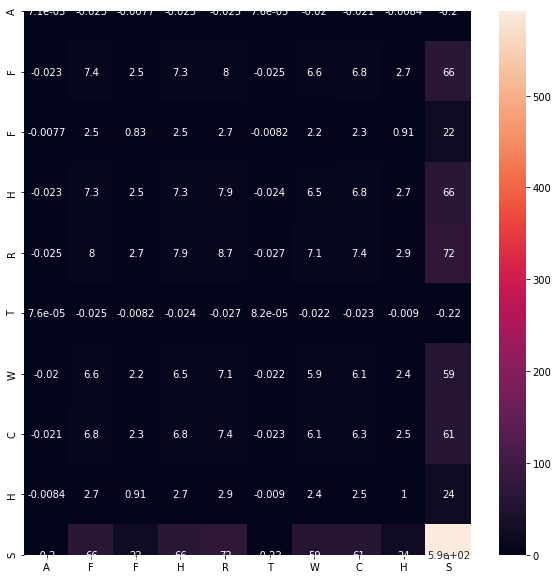

In [18]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
# Action
# Family
# Fantasy
# History
# Romance
# Thriller
# War
# Comedy
# Horror
# ScienceFiction

# out_class_predict_val, out_ground_truth = sess.run([class_predict_val[0], class_gt_val[0]])
# conf_matrix = np.dot(np.expand_dims(out_class_predict_val, 1), np.expand_dims(out_class_predict_val, 0))

df_cm = pd.DataFrame(conf_matrix, index = [i for i in "AFFHRTWCHS"], columns = [i for i in "AFFHRTWCHS"])
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True)

In [12]:
out_ground_truth.shape, out_class_predict_val.shape

((10,), (10,))

In [26]:
import matplotlib.pyplot as plt
from PIL import Image
import importlib
import dataset as dataset
import tensorflow as tf
import numpy as np
import utils as utils
importlib.reload(dataset)
tf.enable_eager_execution()

image = (np.array(Image.open('./Action/__oEU4P_rL8_1020.jpg'))/255.).astype(np.float32)
image_tf= tf.convert_to_tensor(image, dtype=tf.float32)
histogram_u, histogram_v, histogram_gray = dataset.process_image_histogram(image_tf, num_bins=512, values_range=(-10, 10))
# print(histogram_u[1:])
print(tf.reduce_min(histogram_v), tf.reduce_max(histogram_v))

plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray')
plt.show()


ValueError: tf.enable_eager_execution must be called at program startup.

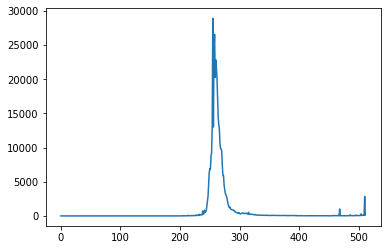

In [28]:
import matplotlib.pyplot as plt
plt.plot(out_input_frames[0, 512:1024])
plt.show()
